# 1.기상 데이터

In [1]:
from scipy.interpolate import CubicSpline
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

paths = glob.glob('./data/temperature_data/seoul/*.csv')

/Users/hits_gold/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.DataFrame()
for path in paths:
    dd = pd.read_csv(path, encoding='cp949')
    data = pd.concat([data, dd])


### - 데이터 유형 변경 및 컬럼명 변경

In [3]:
data['일시'] = pd.to_datetime(data['일시'])
data.columns = ['지점', 'date', '기온', '누적강수량', '풍향', '풍속', '현지기압', '해면기압', '습도', '일사', '일조', '시간']
data = data.sort_values(by = 'date')
data = data[data['date'] < '2023-03-20']

data = data[['date', '기온', '풍속', '습도', '일사', '일조']]

print(f'결측치 제거 전 : {len(data)}')

# 각 행마다 결측값이 하나라도 있으면 행 제거
data = data.dropna(axis = 0).reset_index(drop=True)
print(f'결측치 제거 후 : {len(data)}')

결측치 제거 전 : 4315197
결측치 제거 후 : 4290230


### - 데이터 이상치 확인

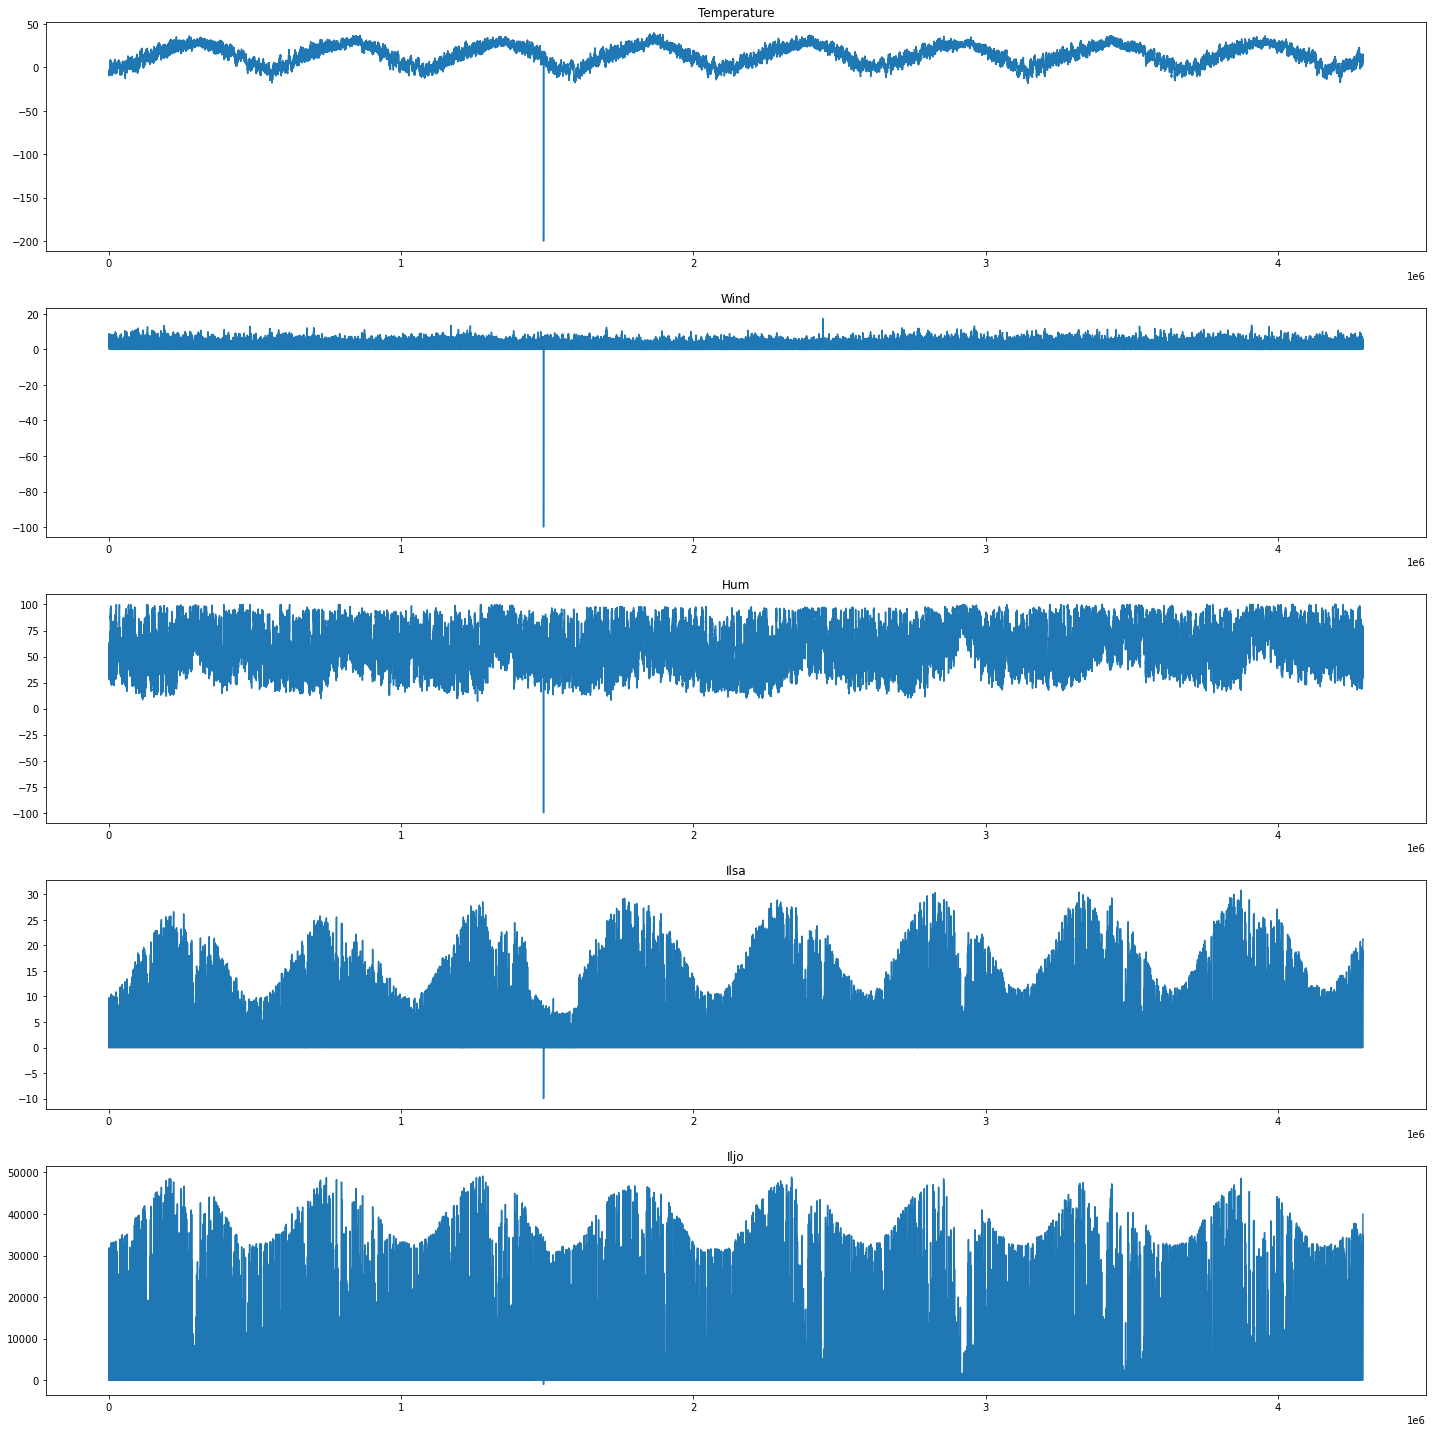

In [4]:
# 기상데이터 이상치 확인 -> 기온, 풍속, 습도,일사에서 이상치가 있는 것으로 보임.

fig,axes = plt.subplots(5,1,figsize=(20,20))

data.기온.plot(ax = axes[0])
axes[0].set_title('Temperature')
data.풍속.plot(ax = axes[1])
axes[1].set_title('Wind')
data.습도.plot(ax = axes[2])
axes[2].set_title('Hum')
data.일사.plot(ax = axes[3])
axes[3].set_title('Ilsa')
data.일조.plot(ax = axes[4])
axes[4].set_title('Iljo')

plt.tight_layout()
plt.show()

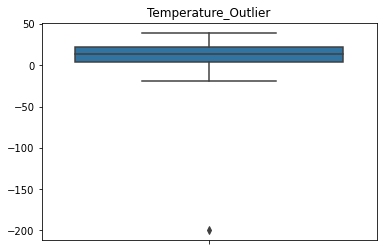

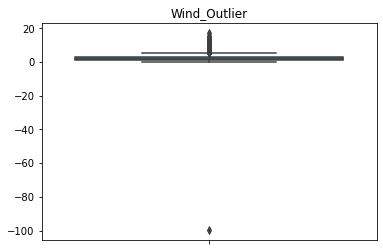

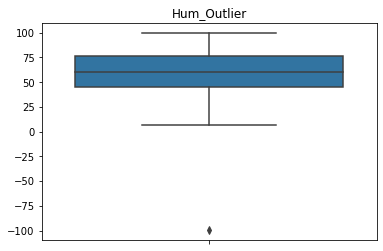

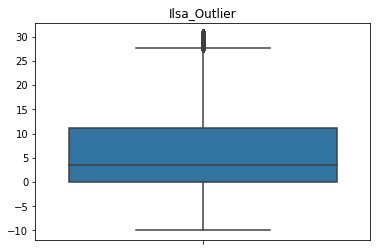

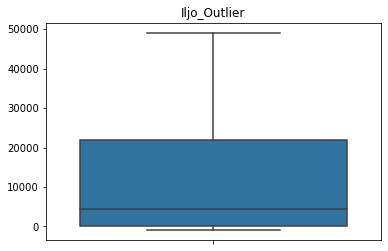

In [5]:
# Box Plot 그려보기
# 일조를 제외한 나머지 데이터들은 이상치들이 존재.
import seaborn as sns
title_name = ['Temperature','Wind','Hum','Ilsa','Iljo']

for idx,i in enumerate(['기온','풍속','습도','일사','일조']):
    plt.figure(figsize=(6,4))
    sns.boxplot(y = data[i].values)
    plt.title(f'{title_name[idx]}_Outlier')
    plt.show()

In [6]:
## IQR을 활용해 이상치를 처리.

def outlier_process(data):
    q3 = np.quantile(data,0.75)
    q1 = np.quantile(data,0.25)
    iqr = q3 - q1
    min_value = q1 - 1.5*iqr
    max_value = q3 + 1.5*iqr
    return min_value, max_value

# 기온 이상치 처리
temp_min, temp_max = outlier_process(data.기온.values)
temp = np.clip(data.기온.values,temp_min,temp_max)


# 풍속 이상치 처리
wind_min, wind_max = outlier_process(data.풍속.values)
wind = np.clip(data.풍속.values,wind_min,wind_max)

# 습도 이상치 처리
hum_min, hum_max = outlier_process(data.습도.values)
hum = np.clip(data.습도.values,hum_min,hum_max)

# 일사 이상치 처리
ilsa_min, ilsa_max = outlier_process(data.일사.values)
ilsa = np.clip(data.일사.values,ilsa_min,ilsa_max)

data.기온 = temp
data.풍속 = wind
data.습도 = hum
data.일사 = ilsa

data.head()


,date,기온,풍속,습도,일사,일조
0,2015-01-01 00:01:00,-6.9,5.55,30.5,0.0,0.0
1,2015-01-01 00:02:00,-6.9,4.90,30.2,0.0,0.0
2,2015-01-01 00:03:00,-6.9,4.60,30.5,0.0,0.0
3,2015-01-01 00:04:00,-6.9,3.90,30.2,0.0,0.0
4,2015-01-01 00:05:00,-6.9,5.55,30.1,0.0,0.0


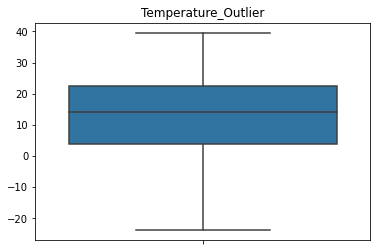

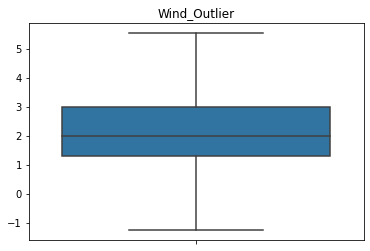

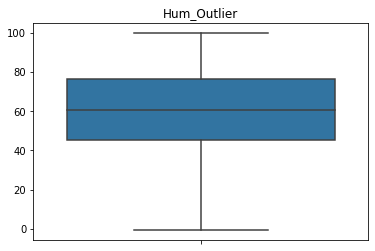

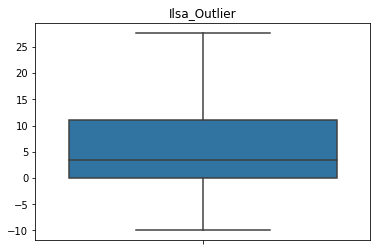

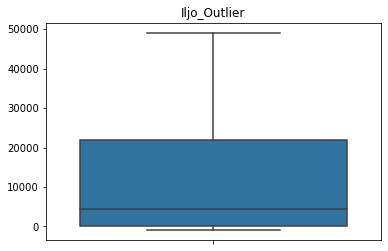

In [7]:
# 이상치 처리 후 Box Plot
import seaborn as sns
title_name = ['Temperature','Wind','Hum','Ilsa','Iljo']

for idx,i in enumerate(['기온','풍속','습도','일사','일조']):
    plt.figure(figsize=(6,4))
    sns.boxplot(y = data[i].values)
    plt.title(f'{title_name[idx]}_Outlier')
    plt.show()

### - date 5분간격 만들기, date 결측값 확인 작업

In [8]:
df = pd.DataFrame()
a = pd.date_range('2015-01-01 00:05:00', '2023-03-19 23:55:00', freq='5min')
df['date'] = a

data = df.merge(data, how='left', on='date')

### - data 결측값 확인 및 보간

In [9]:
data.isnull().sum()

date       0
기온      5950
풍속      5950
습도      5950
일사      5950
일조      5950
dtype: int64

In [10]:
cols = data.columns
for idx in range(1, 6):
    col = cols[idx]
    
    df = data[data[col].notnull()]
    
    cs = CubicSpline(df['date'].values,df[col].values)
    y_inter = cs(data['date'].values)
    
    data[col] = y_inter
    
data.isnull().sum()

date    0
기온      0
풍속      0
습도      0
일사      0
일조      0
dtype: int64

In [11]:
data

,date,기온,풍속,습도,일사,일조
0,2015-01-01 00:05:00,-6.9,5.55,30.1,0.00,0.0
1,2015-01-01 00:10:00,-7.0,5.55,29.6,0.00,0.0
2,2015-01-01 00:15:00,-7.0,4.10,30.0,0.00,0.0
3,2015-01-01 00:20:00,-7.0,4.50,30.2,0.00,0.0
4,2015-01-01 00:25:00,-7.1,5.40,30.1,0.00,0.0
...,...,...,...,...,...,...
863994,2023-03-19 23:35:00,6.4,2.40,70.4,21.25,39900.0
863995,2023-03-19 23:40:00,6.4,2.20,70.5,21.25,39900.0
863996,2023-03-19 23:45:00,6.3,2.10,70.1,21.25,39900.0
863997,2023-03-19 23:50:00,6.3,2.10,68.7,21.25,39900.0


# 2. 전력수요 데이터

In [12]:
paths = glob.glob('./data/raw_data/*.csv')

In [13]:
elec = pd.DataFrame()
for path in paths:
    dd = pd.read_csv(path, encoding='cp949')
    elec = pd.concat([elec, dd])

In [14]:
elec = elec.drop_duplicates('기준일시')

elec = elec[['기준일시', '현재수요(MW)']]
elec.columns = ['date', 'MW']

elec['date'] = pd.to_datetime(elec['date'])
elec = elec[elec['date']>='2015-01-01 00:05:00']
elec = elec[elec['date']<'2023-03-20']

In [15]:
df = pd.DataFrame()
a = pd.date_range('2015-01-01 00:05:00', '2023-03-19 23:55:00', freq='5min')
df['date'] = a

elec = df.merge(elec, how='left', on='date')

## -결측치 확인 및 보간

In [16]:
elec.isnull().sum()

date       0
MW      1091
dtype: int64

In [17]:
elec_ = elec[elec['MW'].notnull()]

cs = CubicSpline(elec_['date'].values,elec_['MW'].values)
y_inter = cs(elec['date'].values)

elec['MW'] = y_inter

# 3. 데이터 병합 및 저장

In [18]:
result = pd.merge(elec, data, on = 'date')

In [19]:
result.to_csv('./data/data2015.csv',index = False)

# 4. 서로 다른 기간의 데이터 생성 및 저장

In [20]:
data_2015 = pd.read_csv('./data/data2015.csv')

In [21]:
data_2016 = data_2015.iloc[data_2015.query('date == "2016-01-01 00:00:00"').index[0]:]
data_2017 = data_2015.iloc[data_2015.query('date == "2017-01-01 00:00:00"').index[0]:]
data_2018 = data_2015.iloc[data_2015.query('date == "2018-01-01 00:00:00"').index[0]:]
data_2019 = data_2015.iloc[data_2015.query('date == "2019-01-01 00:00:00"').index[0]:]

In [22]:
data_2016.to_csv('./data/data2016.csv',index = False)
data_2017.to_csv('./data/data2017.csv',index = False)
data_2018.to_csv('./data/data2018.csv',index = False)
data_2019.to_csv('./data/data2019.csv',index = False)

In [23]:
# Pred Inference를 위한 데이터 생성
data_2015.iloc[-2016*3:].reset_index(drop = True).to_csv('./data/pred.csv',index = False)